This group assignment done by:

1.Nalla Janardhana Rao - MDS202426

2.Pranav Pothan               - MDS202429

3.Raja S  - MDS202430

Task 1: Classifier for notMNIST

Step 1 —  load the notMNIST dataset

In [ ]:
!pip install -q datasets huggingface_hub

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset


In [ ]:
ds = load_dataset("anubhavmaity/notMNIST")

In [ ]:
print(ds)
print("Train size:", len(ds["train"]))
print("Test size :", len(ds["test"]))
print("Features:", ds["train"].features)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
})
Train size: 14979
Test size : 3745
Features: {'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])}


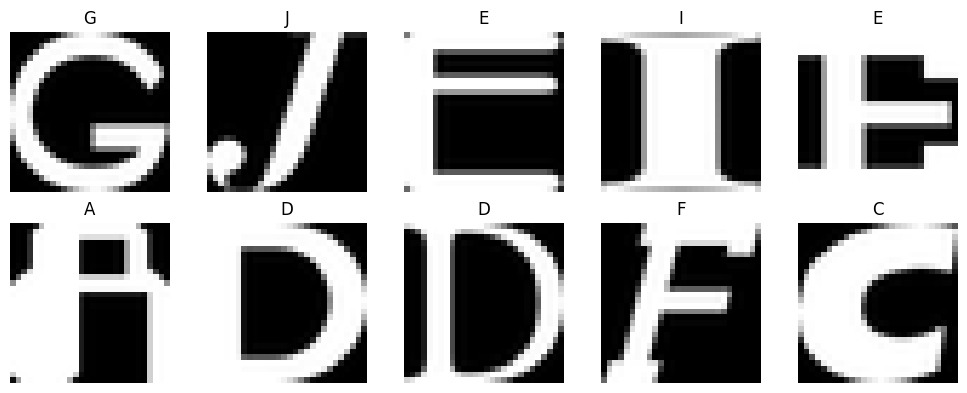

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i, ax in enumerate(axes.flatten()):
    item = ds["train"][i]
    img = item["image"]
    lbl = item["label"]
    ax.imshow(img, cmap="gray")
    ax.set_title(chr(ord("A")+int(lbl)))
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def dataset_to_arrays(dset):
    images = np.stack([np.array(x["image"]) for x in dset])   # shape (N, 28, 28)
    labels = np.array(dset["label"], dtype=np.int32)
    return images, labels


In [ ]:
train_images, train_labels = dataset_to_arrays(ds["train"])
test_images, test_labels   = dataset_to_arrays(ds["test"])


In [ ]:
print("train_images.shape:", train_images.shape, "train_labels.shape:", train_labels.shape)
print("test_images.shape :", test_images.shape, "test_labels.shape :", test_labels.shape)

train_images.shape: (14979, 28, 28) train_labels.shape: (14979,)
test_images.shape : (3745, 28, 28) test_labels.shape : (3745,)


Step 2 : Preprocessing for CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [ ]:
# 1) Normalize images
train_images = train_images.astype("float32") / 255.0
test_images  = test_images.astype("float32") / 255.0

In [ ]:
# 2) Add channel dimension (28,28) -> (28,28,1)
train_images = np.expand_dims(train_images, -1)
test_images  = np.expand_dims(test_images, -1)

print("train_images shape:", train_images.shape)
print("test_images shape :", test_images.shape)


train_images shape: (14979, 28, 28, 1, 1)
test_images shape : (3745, 28, 28, 1, 1)


In [ ]:
# 3) One-hot encode labels (10 classes: A..J)
num_classes = 10
train_labels_cat = to_categorical(train_labels, num_classes)
test_labels_cat  = to_categorical(test_labels, num_classes)

print("train_labels_cat shape:", train_labels_cat.shape)
print("test_labels_cat shape :", test_labels_cat.shape)

train_labels_cat shape: (14979, 10)
test_labels_cat shape : (3745, 10)


Step 3 — Define the CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),   # helps prevent overfitting
    Dense(10, activation='softmax')  # 10 classes (A..J)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Step 4 — Train & Evaluate the CNN

In [ ]:
# Train the model
history = model.fit(
    train_images, train_labels_cat,
    epochs=20,
    batch_size=128,
    validation_data=(test_images, test_labels_cat),
    verbose=2
)

Epoch 1/20
118/118 - 1s - 6ms/step - accuracy: 0.9822 - loss: 0.0456 - val_accuracy: 0.9314 - val_loss: 0.3394
Epoch 2/20
118/118 - 1s - 5ms/step - accuracy: 0.9847 - loss: 0.0401 - val_accuracy: 0.9351 - val_loss: 0.3706
Epoch 3/20
118/118 - 1s - 5ms/step - accuracy: 0.9829 - loss: 0.0451 - val_accuracy: 0.9343 - val_loss: 0.3597
Epoch 4/20
118/118 - 1s - 5ms/step - accuracy: 0.9814 - loss: 0.0480 - val_accuracy: 0.9351 - val_loss: 0.3557
Epoch 5/20
118/118 - 1s - 5ms/step - accuracy: 0.9837 - loss: 0.0414 - val_accuracy: 0.9359 - val_loss: 0.3760
Epoch 6/20
118/118 - 1s - 5ms/step - accuracy: 0.9826 - loss: 0.0464 - val_accuracy: 0.9330 - val_loss: 0.3813
Epoch 7/20
118/118 - 1s - 11ms/step - accuracy: 0.9814 - loss: 0.0476 - val_accuracy: 0.9367 - val_loss: 0.3578
Epoch 8/20
118/118 - 1s - 5ms/step - accuracy: 0.9840 - loss: 0.0432 - val_accuracy: 0.9367 - val_loss: 0.3783
Epoch 9/20
118/118 - 1s - 5ms/step - accuracy: 0.9830 - loss: 0.0422 - val_accuracy: 0.9351 - val_loss: 0.3680


In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, test_labels_cat, verbose=0)
print(f"\n Test Accuracy: {test_acc:.4f}")
print(f" Test Loss    : {test_loss:.4f}")


 Test Accuracy: 0.9367
 Test Loss    : 0.3916


Step 5 — Plot Training History

In [ ]:
import matplotlib.pyplot as plt

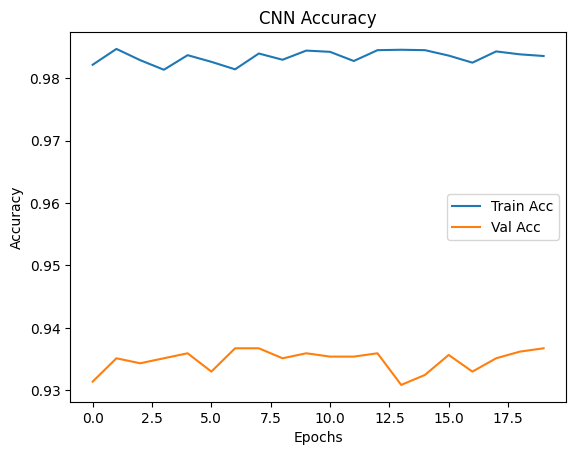

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


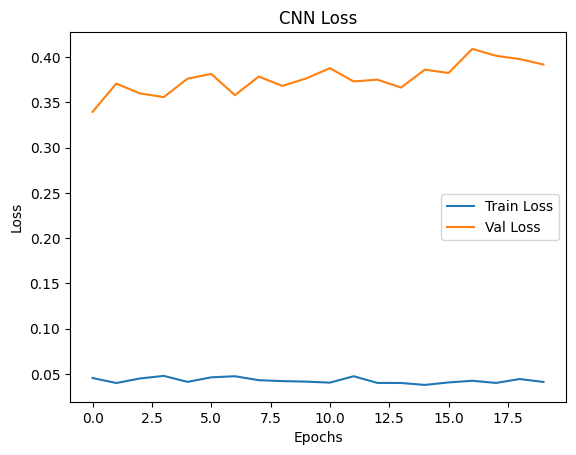

In [ ]:
# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Step 6 — Pixel Permutation Experiment

In [ ]:
# 1) Create a fixed random permutation of pixel indices
num_pixels = 28 * 28
perm = np.random.permutation(num_pixels)


In [ ]:
def permute_images(images):
    # reshape to (N, 784), permute, then reshape back to (28,28,1)
    N = images.shape[0]
    flat = images.reshape(N, num_pixels)
    flat_perm = flat[:, perm]
    return flat_perm.reshape(N, 28, 28, 1)

# Apply permutation
train_images_perm = permute_images(train_images)
test_images_perm  = permute_images(test_images)

print("Original shape:", train_images.shape, "Permuted shape:", train_images_perm.shape)

Original shape: (14979, 28, 28, 1, 1) Permuted shape: (14979, 28, 28, 1)


In [ ]:
# 2) Define the same CNN as before (simple model)
perm_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [ ]:
perm_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# 3) Train on permuted dataset
history_perm = perm_model.fit(
    train_images_perm, train_labels_cat,
    epochs=15,
    batch_size=128,
    validation_data=(test_images_perm, test_labels_cat),
    verbose=2
)

Epoch 1/15
118/118 - 6s - 48ms/step - accuracy: 0.5376 - loss: 1.4626 - val_accuracy: 0.8182 - val_loss: 0.6510
Epoch 2/15
118/118 - 1s - 5ms/step - accuracy: 0.8230 - loss: 0.6310 - val_accuracy: 0.8753 - val_loss: 0.4407
Epoch 3/15
118/118 - 1s - 5ms/step - accuracy: 0.8550 - loss: 0.5105 - val_accuracy: 0.8903 - val_loss: 0.3964
Epoch 4/15
118/118 - 1s - 5ms/step - accuracy: 0.8738 - loss: 0.4416 - val_accuracy: 0.8977 - val_loss: 0.3638
Epoch 5/15
118/118 - 1s - 5ms/step - accuracy: 0.8808 - loss: 0.4141 - val_accuracy: 0.8972 - val_loss: 0.3413
Epoch 6/15
118/118 - 1s - 5ms/step - accuracy: 0.8959 - loss: 0.3626 - val_accuracy: 0.8967 - val_loss: 0.3375
Epoch 7/15
118/118 - 1s - 6ms/step - accuracy: 0.8985 - loss: 0.3391 - val_accuracy: 0.9031 - val_loss: 0.3257
Epoch 8/15
118/118 - 1s - 6ms/step - accuracy: 0.9110 - loss: 0.3024 - val_accuracy: 0.9017 - val_loss: 0.3162
Epoch 9/15
118/118 - 1s - 10ms/step - accuracy: 0.9168 - loss: 0.2729 - val_accuracy: 0.9060 - val_loss: 0.3045

Step 7 —  Accuracy Comparison

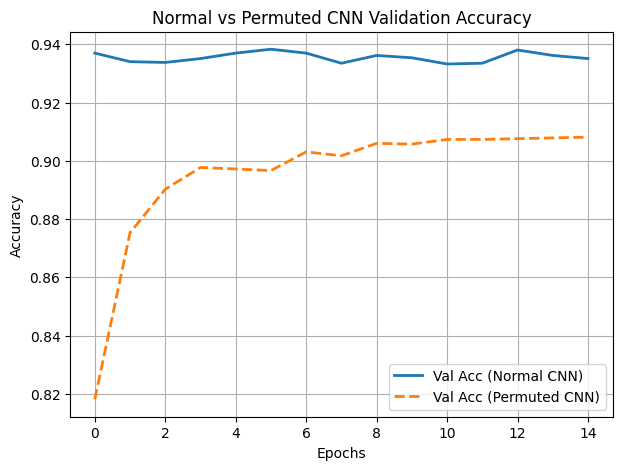

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Plot normal CNN validation accuracy
plt.plot(history.history['val_accuracy'], label='Val Acc (Normal CNN)', linewidth=2)

# Plot permuted CNN validation accuracy
plt.plot(history_perm.history['val_accuracy'], label='Val Acc (Permuted CNN)', linewidth=2, linestyle='--')

plt.title("Normal vs Permuted CNN Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Task 2: Building a Resnet-18 classifier for the Emotion Detection Dataset


Step 1: Kaggle setup & dataset download

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
  0% 0.00/65.2M [00:00<?, ?B/s]
100% 65.2M/65.2M [00:00<00:00, 1.68GB/s]


In [ ]:
# Check the contents after extraction
!ls -la /content

total 28
drwxr-xr-x 1 root root 4096 Sep 26 17:02 .
drwxr-xr-x 1 root root 4096 Sep 26 16:58 ..
drwxr-xr-x 4 root root 4096 Sep 25 13:36 .config
-rw-r--r-- 1 root root   68 Sep 26 17:02 kaggle.json
drwxr-xr-x 1 root root 4096 Sep 25 13:37 sample_data
drwxr-xr-x 9 root root 4096 Sep 26 17:02 test
drwxr-xr-x 9 root root 4096 Sep 26 17:02 train


Step 2: Imports, device setup, dataset paths check

In [ ]:
import os, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models


In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

Device in use: cuda


In [ ]:
# Paths to dataset
DATA_ROOT = "/content"
train_dir = os.path.join(DATA_ROOT, "train")
test_dir  = os.path.join(DATA_ROOT, "test")

In [ ]:
print("Train dir contains classes:", os.listdir(train_dir))
print("Test dir contains classes:", os.listdir(test_dir))

Train dir contains classes: ['sad', 'disgusted', 'angry', 'neutral', 'fearful', 'surprised', 'happy']
Test dir contains classes: ['sad', 'disgusted', 'angry', 'neutral', 'fearful', 'surprised', 'happy']


Step 3: Transforms + Datasets + DataLoaders

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


In [ ]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # convert grayscale → RGB
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load full training dataset first
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)


In [ ]:
# Split into train/val (e.g., 80% / 20%)
train_size = int(0.8 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))


In [ ]:
# Apply eval_transform to validation dataset
val_dataset.dataset.transform = eval_transform

In [ ]:
# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=eval_transform)

In [ ]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# Class names
classes = full_train_dataset.classes
num_classes = len(classes)

print(f"Total images: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print("Classes:", classes)

Total images: Train=22967, Val=5742, Test=7178
Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


Step 4: Build ResNet-18 (from scratch)

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Create ResNet-18 without pretrained weights (from scratch)
try:
    model_scratch = models.resnet18(weights=None)   # for newer torchvision
except TypeError:
    model_scratch = models.resnet18(pretrained=False)  # fallback for older versions

In [ ]:
# Replace final fully connected layer with correct number of classes
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
# Move to GPU if available
model_scratch = model_scratch.to(device)
print(model_scratch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_scratch.parameters(),
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters (scratch model):", count_parameters(model_scratch))

Trainable parameters (scratch model): 11180103


Step 5: Training & Validation Loop for the scratch model.

In [ ]:
import time
import copy

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                scheduler.step()
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (train_loss_history, val_loss_history, train_acc_history, val_acc_history)

# Train the scratch model
model_scratch, history_scratch = train_model(model_scratch, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
--------------------
train Loss: 1.7994 Acc: 0.2811
val Loss: 1.5643 Acc: 0.3918

Epoch 2/15
--------------------
train Loss: 1.4877 Acc: 0.4283
val Loss: 1.5471 Acc: 0.3842

Epoch 3/15
--------------------
train Loss: 1.3151 Acc: 0.4992
val Loss: 1.4393 Acc: 0.4916

Epoch 4/15
--------------------
train Loss: 1.1793 Acc: 0.5533
val Loss: 1.4396 Acc: 0.4794

Epoch 5/15
--------------------
train Loss: 1.0715 Acc: 0.5986
val Loss: 1.1905 Acc: 0.5522

Epoch 6/15
--------------------
train Loss: 0.9548 Acc: 0.6414
val Loss: 1.4177 Acc: 0.5003

Epoch 7/15
--------------------
train Loss: 0.8237 Acc: 0.6930
val Loss: 1.4127 Acc: 0.5378

Epoch 8/15
--------------------
train Loss: 0.3803 Acc: 0.8772
val Loss: 1.2320 Acc: 0.6029

Epoch 9/15
--------------------
train Loss: 0.2012 Acc: 0.9456
val Loss: 1.3504 Acc: 0.6041

Epoch 10/15
--------------------
train Loss: 0.1171 Acc: 0.9743
val Loss: 1.4687 Acc: 0.5993

Epoch 11/15
--------------------
train Loss: 0.0662 Acc: 0.9896
val L

Step 6: Evaluate on test set + Plot curves + Confusion Matrix.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
model_scratch.eval()
test_loss = 0.0
corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_scratch(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_acc = corrects.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")

Test Loss: 1.3704  Test Acc: 0.5913


In [ ]:
# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))



Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.50      0.50       958
   disgusted       0.81      0.39      0.52       111
     fearful       0.48      0.32      0.39      1024
       happy       0.77      0.84      0.80      1774
     neutral       0.54      0.52      0.53      1233
         sad       0.42      0.53      0.47      1247
   surprised       0.76      0.73      0.74       831

    accuracy                           0.59      7178
   macro avg       0.61      0.55      0.57      7178
weighted avg       0.59      0.59      0.59      7178



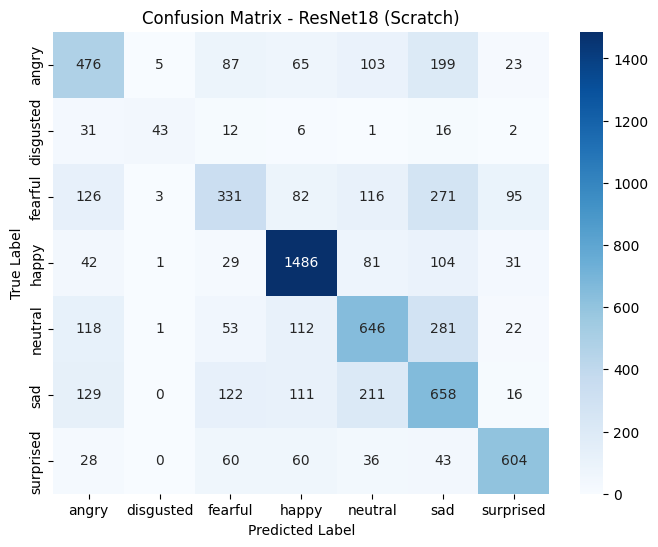

In [ ]:
# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix - ResNet18 (Scratch)")
plt.show()

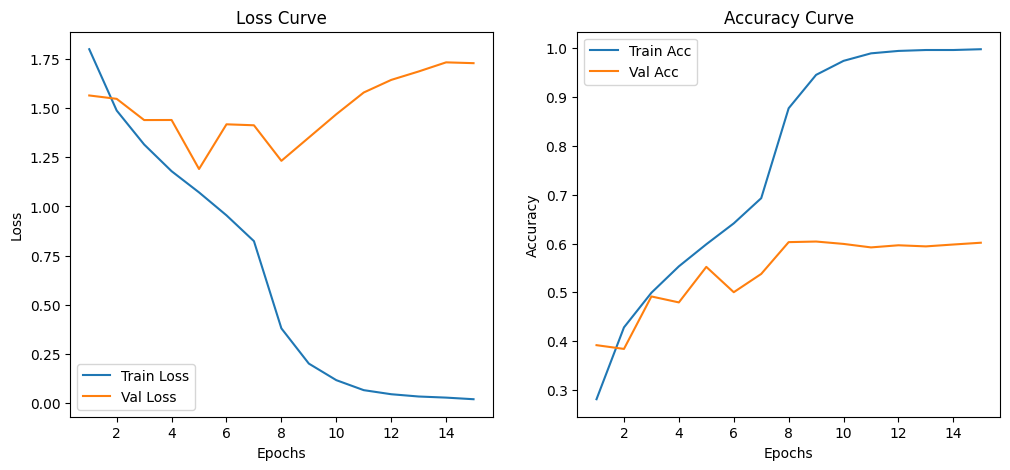

In [ ]:
# ---- Plot Accuracy/Loss Curves ----
train_loss, val_loss, train_acc, val_acc = history_scratch

epochs = range(1, len(train_loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

Step 7: Fine-tuning a pretrained ResNet-18.

In [ ]:
def build_pretrained_model(freeze_layers=[]):
    """
    freeze_layers: list of layer names to freeze, e.g. ['layer1', 'layer2']
    """
    try:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except:
        model = models.resnet18(pretrained=True)

    # Freeze specified layers
    for lname in freeze_layers:
        layer = getattr(model, lname)
        for param in layer.parameters():
            param.requires_grad = False

    # Replace final layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

In [ ]:
results_log = {}   # key = model_name, value = dict with val_acc, test_acc

def evaluate_on_test(model, model_name):
    """Evaluate a trained model on the test set and log results."""
    model.eval()
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels).item()
            total += labels.size(0)
    test_acc = corrects / total
    print(f"{model_name} -> Test Accuracy: {test_acc:.4f}")
    return test_acc

# ----------------- Experiment 1 -----------------
print("Experiment 1: Freeze layer1 only")

model_ft1 = build_pretrained_model(freeze_layers=['layer1'])
criterion = nn.CrossEntropyLoss()
optimizer_ft1 = optim.Adam(filter(lambda p: p.requires_grad, model_ft1.parameters()), lr=1e-4)
scheduler_ft1 = optim.lr_scheduler.StepLR(optimizer_ft1, step_size=7, gamma=0.1)

# Train
model_ft1, history_ft1 = train_model(model_ft1, criterion, optimizer_ft1, scheduler_ft1, num_epochs=10)

# Save
torch.save(model_ft1.state_dict(), "resnet18_ft_layer1.pth")
print("Model saved as resnet18_ft_layer1.pth")

# Log results
val_acc1 = max(history_ft1[3])   # validation accuracy history
test_acc1 = evaluate_on_test(model_ft1, "ResNet18_FT_Layer1")
results_log["ResNet18_FT_Layer1"] = {"val_acc": val_acc1, "test_acc": test_acc1}

# Also log scratch model (so we don't forget later)
if "ResNet18_Scratch" not in results_log:
    val_acc_scratch = max(history_scratch[3])
    # evaluate scratch model on test set
    test_acc_scratch = evaluate_on_test(model_scratch, "ResNet18_Scratch")
    results_log["ResNet18_Scratch"] = {"val_acc": val_acc_scratch, "test_acc": test_acc_scratch}

print("\nCurrent results log:")
print(results_log)

Experiment 1: Freeze layer1 only
Epoch 1/10
--------------------
train Loss: 1.1632 Acc: 0.5609
val Loss: 1.0026 Acc: 0.6313

Epoch 2/10
--------------------
train Loss: 0.8128 Acc: 0.7018
val Loss: 0.9974 Acc: 0.6414

Epoch 3/10
--------------------
train Loss: 0.5022 Acc: 0.8214
val Loss: 1.1206 Acc: 0.6454

Epoch 4/10
--------------------
train Loss: 0.2343 Acc: 0.9240
val Loss: 1.2543 Acc: 0.6548

Epoch 5/10
--------------------
train Loss: 0.1339 Acc: 0.9597
val Loss: 1.4868 Acc: 0.6339

Epoch 6/10
--------------------
train Loss: 0.1061 Acc: 0.9676
val Loss: 1.5605 Acc: 0.6409

Epoch 7/10
--------------------
train Loss: 0.0960 Acc: 0.9708
val Loss: 1.6302 Acc: 0.6515

Epoch 8/10
--------------------
train Loss: 0.0476 Acc: 0.9875
val Loss: 1.4463 Acc: 0.6654

Epoch 9/10
--------------------
train Loss: 0.0215 Acc: 0.9963
val Loss: 1.4529 Acc: 0.6675

Epoch 10/10
--------------------
train Loss: 0.0147 Acc: 0.9973
val Loss: 1.4480 Acc: 0.6700

Training complete in 13m 29s
Best va

In [33]:
# ----------------- Experiment 2 -----------------
print("Experiment 2: Freeze layer1 + layer2")

model_ft2 = build_pretrained_model(freeze_layers=['layer1', 'layer2'])
criterion = nn.CrossEntropyLoss()
optimizer_ft2 = optim.Adam(filter(lambda p: p.requires_grad, model_ft2.parameters()), lr=1e-4)
scheduler_ft2 = optim.lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)

model_ft2, history_ft2 = train_model(model_ft2, criterion, optimizer_ft2, scheduler_ft2, num_epochs=10)

torch.save(model_ft2.state_dict(), "resnet18_ft_layer1_layer2.pth")
print("Model saved as resnet18_ft_layer1_layer2.pth")

val_acc2 = max(history_ft2[3])
test_acc2 = evaluate_on_test(model_ft2, "ResNet18_FT_Layer1+2")
results_log["ResNet18_FT_Layer1+2"] = {"val_acc": val_acc2, "test_acc": test_acc2}


# ----------------- Experiment 3 -----------------
print("\nExperiment 3: Freeze layer1 + layer2 + layer3")

model_ft3 = build_pretrained_model(freeze_layers=['layer1', 'layer2', 'layer3'])
criterion = nn.CrossEntropyLoss()
optimizer_ft3 = optim.Adam(filter(lambda p: p.requires_grad, model_ft3.parameters()), lr=1e-4)
scheduler_ft3 = optim.lr_scheduler.StepLR(optimizer_ft3, step_size=7, gamma=0.1)

model_ft3, history_ft3 = train_model(model_ft3, criterion, optimizer_ft3, scheduler_ft3, num_epochs=10)

torch.save(model_ft3.state_dict(), "resnet18_ft_layer1_layer2_layer3.pth")
print("Model saved as resnet18_ft_layer1_layer2_layer3.pth")

val_acc3 = max(history_ft3[3])
test_acc3 = evaluate_on_test(model_ft3, "ResNet18_FT_Layer1+2+3")
results_log["ResNet18_FT_Layer1+2+3"] = {"val_acc": val_acc3, "test_acc": test_acc3}


# ----------------- Experiment 4 -----------------
print("\nExperiment 4: Freeze ALL convolutional layers (only FC trainable)")

# For freezing all: conv1, bn1, layer1–4
model_ft4 = build_pretrained_model(freeze_layers=['layer1', 'layer2', 'layer3', 'layer4'])
for param in model_ft4.conv1.parameters():
    param.requires_grad = False
for param in model_ft4.bn1.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer_ft4 = optim.Adam(filter(lambda p: p.requires_grad, model_ft4.parameters()), lr=1e-4)
scheduler_ft4 = optim.lr_scheduler.StepLR(optimizer_ft4, step_size=7, gamma=0.1)

model_ft4, history_ft4 = train_model(model_ft4, criterion, optimizer_ft4, scheduler_ft4, num_epochs=10)

torch.save(model_ft4.state_dict(), "resnet18_ft_all_frozen.pth")
print("Model saved as resnet18_ft_all_frozen.pth")

val_acc4 = max(history_ft4[3])
test_acc4 = evaluate_on_test(model_ft4, "ResNet18_FT_AllFrozen")
results_log["ResNet18_FT_AllFrozen"] = {"val_acc": val_acc4, "test_acc": test_acc4}


# ----------------- Print final log -----------------
print("\n===== Final Results Log =====")
for k, v in results_log.items():
    print(f"{k}: Val Acc={v['val_acc']:.4f}, Test Acc={v['test_acc']:.4f}")


Experiment 2: Freeze layer1 + layer2
Epoch 1/10
--------------------
train Loss: 1.1732 Acc: 0.5607
val Loss: 1.0222 Acc: 0.6177

Epoch 2/10
--------------------
train Loss: 0.8226 Acc: 0.6970
val Loss: 1.0278 Acc: 0.6341

Epoch 3/10
--------------------
train Loss: 0.4746 Acc: 0.8342
val Loss: 1.1317 Acc: 0.6331

Epoch 4/10
--------------------
train Loss: 0.1977 Acc: 0.9376
val Loss: 1.3367 Acc: 0.6306

Epoch 5/10
--------------------
train Loss: 0.1024 Acc: 0.9725
val Loss: 1.5422 Acc: 0.6238

Epoch 6/10
--------------------
train Loss: 0.0814 Acc: 0.9764
val Loss: 1.6689 Acc: 0.6188

Epoch 7/10
--------------------
train Loss: 0.0886 Acc: 0.9727
val Loss: 1.6765 Acc: 0.6264

Epoch 8/10
--------------------
train Loss: 0.0417 Acc: 0.9891
val Loss: 1.5350 Acc: 0.6562

Epoch 9/10
--------------------
train Loss: 0.0188 Acc: 0.9970
val Loss: 1.5367 Acc: 0.6597

Epoch 10/10
--------------------
train Loss: 0.0129 Acc: 0.9976
val Loss: 1.5445 Acc: 0.6552

Training complete in 12m 51s
Bes

Step 8: Comparison plots + results table

===== Final Results Table =====
                         val_acc  test_acc
ResNet18_FT_Layer1      0.669976  0.667177
ResNet18_FT_Layer1+2    0.659700  0.654918
ResNet18_FT_Layer1+2+3  0.645768  0.628866
ResNet18_Scratch        0.604145  0.591251
ResNet18_FT_AllFrozen   0.423720  0.423934


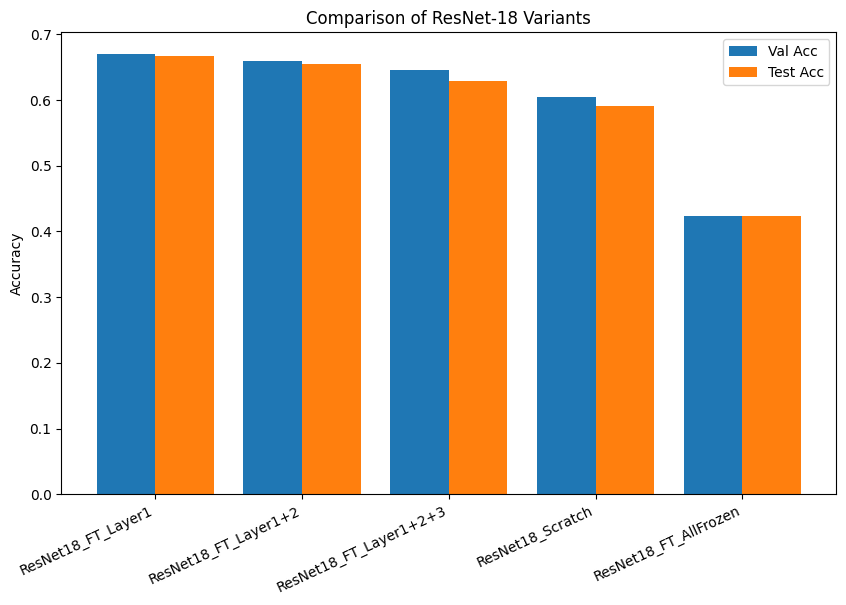

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results_log dict -> pandas DataFrame
df_results = pd.DataFrame(results_log).T  # transpose
df_results = df_results.sort_values("val_acc", ascending=False)

print("===== Final Results Table =====")
print(df_results)

# Plot comparison bar chart
plt.figure(figsize=(10,6))
x = range(len(df_results))
plt.bar([i-0.2 for i in x], df_results["val_acc"], width=0.4, label="Val Acc")
plt.bar([i+0.2 for i in x], df_results["test_acc"], width=0.4, label="Test Acc")
plt.xticks(x, df_results.index, rotation=25, ha="right")
plt.ylabel("Accuracy")
plt.title("Comparison of ResNet-18 Variants")
plt.legend()
plt.show()

Step 9: Confusion matrix for the best-performing model


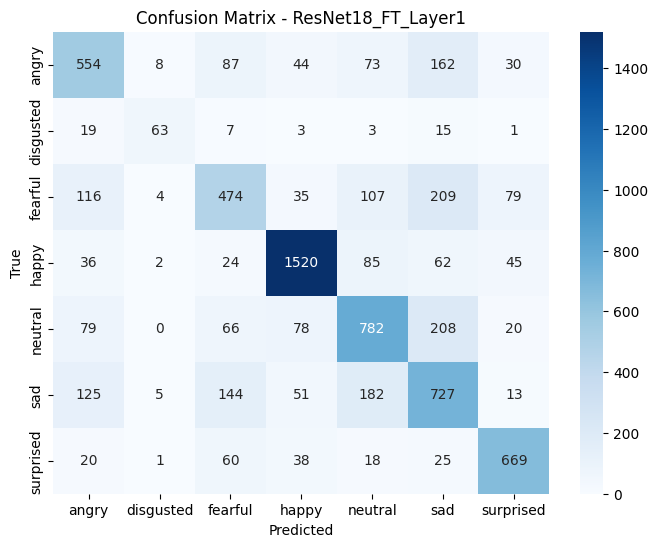


Classification Report for ResNet18_FT_Layer1:
              precision    recall  f1-score   support

       angry       0.58      0.58      0.58       958
   disgusted       0.76      0.57      0.65       111
     fearful       0.55      0.46      0.50      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.63      0.63      0.63      1233
         sad       0.52      0.58      0.55      1247
   surprised       0.78      0.81      0.79       831

    accuracy                           0.67      7178
   macro avg       0.67      0.64      0.65      7178
weighted avg       0.67      0.67      0.67      7178



In [37]:
# Step 9: Confusion Matrix for ResNet18_FT_Layer1 only

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Rebuild model (freeze layer1) to match saved checkpoint
best_model = build_pretrained_model(freeze_layers=['layer1'])

# Replace FC layer
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved weights
best_model.load_state_dict(torch.load("resnet18_ft_layer1.pth"))
best_model = best_model.to(device)
best_model.eval()

# Collect predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet18_FT_Layer1")
plt.show()

# Classification Report
print("\nClassification Report for ResNet18_FT_Layer1:")
print(classification_report(all_labels, all_preds, target_names=classes))


#  Analysis of Results

## 1. Model Performance Summary
We trained and evaluated different variants of **ResNet-18** on the Emotion Detection dataset:

| Model Variant              | Val Accuracy | Test Accuracy |
|-----------------------------|--------------|---------------|
| ResNet18 (Scratch)          | 60.4%        | 59.1%         |
| ResNet18 (FT: Layer1)       | **67.0%**    | **66.7%**     |
| ResNet18 (FT: Layer1+2)     | 65.9%        | 65.5%         |
| ResNet18 (FT: Layer1+2+3)   | 64.6%        | 62.9%         |
| ResNet18 (FT: All Frozen)   | 42.4%        | 42.4%         |

**Key Observations:**
- Training **from scratch** (no pretraining) performed the worst among fine-tuned models, achieving only ~59% test accuracy.  
- **Fine-tuning with only `layer1` frozen** gave the **best performance (66.7% test accuracy)**.  
- Freezing more layers (`layer1+2`, `layer1+2+3`) led to **slight drops in accuracy**, showing that allowing deeper layers to adapt helps.  
- Freezing **all convolutional layers** and only training the final FC layer severely underperformed (~42%), since the model could not adapt enough to emotion-specific features.  

---

## 2. Confusion Matrix (Best Model: ResNet18_FT_Layer1)
The confusion matrix shows how well the model distinguished between the 7 emotion classes:

- Strong recognition for **Happy** and **Neutral** classes.  
- Higher confusion between **Fearful, Sad, and Angry** emotions, which share visual similarities in facial expressions.  
- **Disgusted** and **Surprised** were moderately well recognized but still showed overlaps with Angry/Happy.

---

## 3. Classification Report Insights
- **Happy**: Highest precision and recall — easier to detect due to distinct facial cues.  
- **Neutral**: Performed reasonably well but often confused with Sad.  
- **Fearful vs Sad vs Angry**: Lower precision/recall — overlapping features make them harder to separate.  
- **Disgusted**: Moderate performance, often confused with Angry.  
- **Surprised**: Reasonably good detection, though sometimes misclassified as Happy.

---

## 4. Overall Conclusion
- **Pretrained ResNet-18 with partial fine-tuning clearly outperforms training from scratch.**
- Best tradeoff was freezing **only the first block (`layer1`)**, achieving ~67% test accuracy.  


---
